In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.utils import to_categorical
import keras
import sys, time, os, warnings 
import numpy as np
import pandas as pd 
from collections import Counter 

Using TensorFlow backend.


In [2]:
def set_seed(sd=123):
    from numpy.random import seed
    from tensorflow import set_random_seed
    import random as rn
    ## numpy random seed
    seed(sd)
    ## core python's random number 
    rn.seed(sd)
    ## tensor flow's random number
    set_random_seed(sd)

In [3]:
## The location of the Flickr8K_ photos
data_image = "flickr30k-images"
## The location of the caption file
caption= "flickr30k/results_20130124.token"

jpgs = os.listdir(data_image)
print("The number of jpg flies in Flicker30k: {}".format(len(jpgs)))


The number of jpg flies in Flicker30k: 31783


In [4]:
## read in the Flickr caption data
file = open(caption,'r',encoding="utf8")
text = file.read()
file.close()

#splitting captions and creating a dataframe
datatxt = []
for line in text.split('\n'):
    col = line.split('\t')
    if len(col) == 1:
        continue
    w = col[0].split("#")
    datatxt.append(w + [col[1].lower()])

df_txt = pd.DataFrame(datatxt,columns=["filename","index","caption"])


uni_filenames = np.unique(df_txt.filename.values)
print("The number of unique file names : {}".format(len(uni_filenames)))
print("The distribution of the number of captions for each image:" )
Counter(Counter(df_txt.filename.values).values())

The number of unique file names : 31783
The distribution of the number of captions for each image:


Counter({5: 31783})

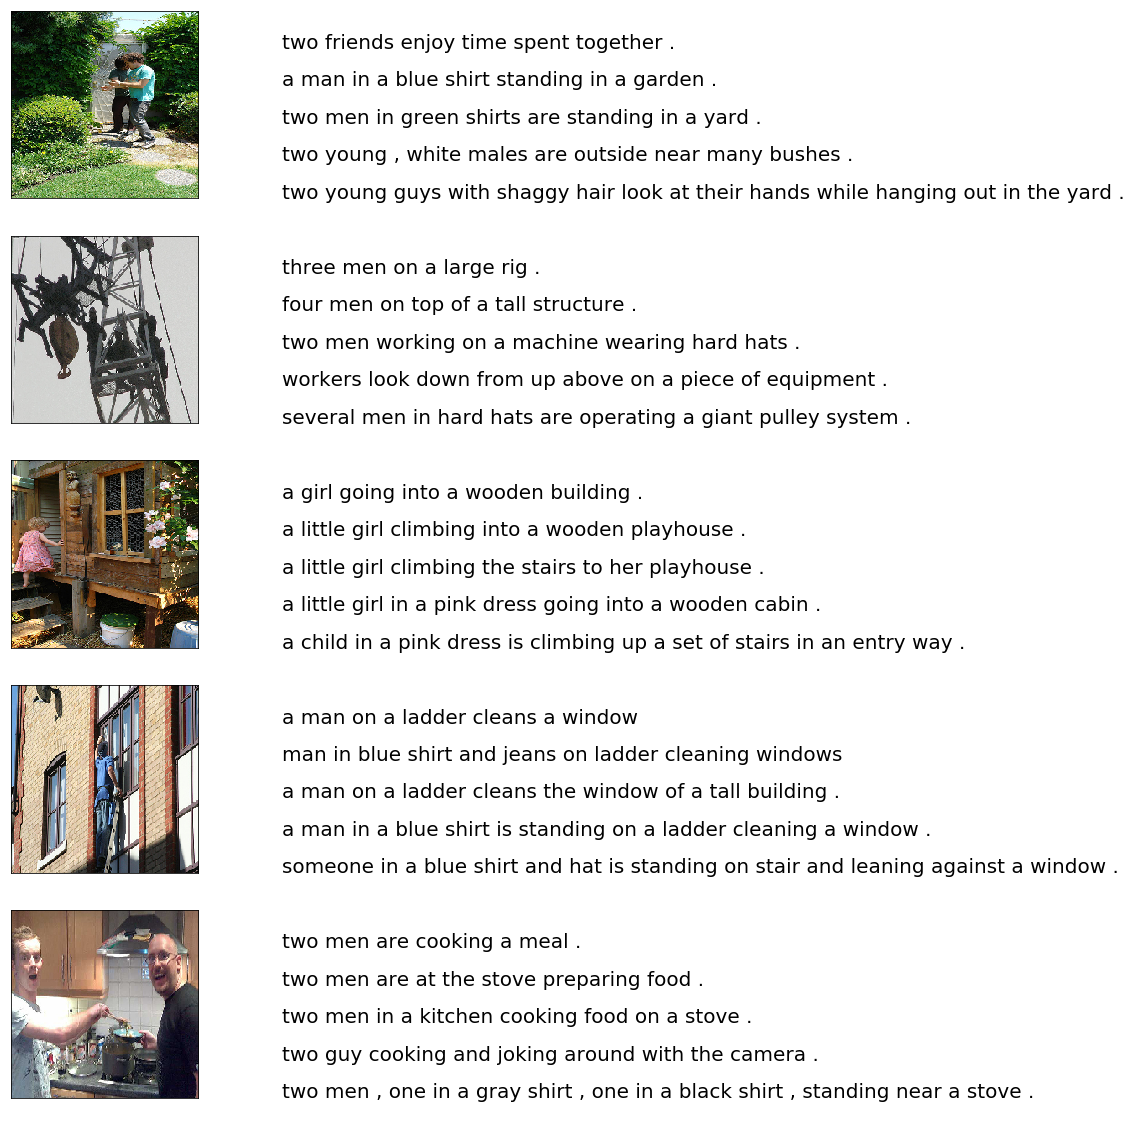

In [5]:
#image and captions

from keras.preprocessing.image import load_img, img_to_array

npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[:npic]:
    filename = data_image + '/' + jpgfnm
    captions = list(df_txt["caption"].loc[df_txt["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1
    
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontsize=20)
    count += 1
plt.show()

In [6]:
#generating vocabulary from the captions

def df_word(df_txt):
    vocabulary = []
    for txt in df_txt.caption.values:
        vocabulary.extend(txt.split())
    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter()
    for word in vocabulary:
        ct[word] += 1
    print(ct.most_common(10))    
    dfword = pd.DataFrame.from_dict(ct, orient='index').reset_index()
    dfword = dfword.rename(columns={'index':'Word', 0:'Count'})
    dfword = dfword.sort_values(by=['Count'],ascending= False)
#     dfword = dfword.reset_index()[["word","count"]]
    return(dfword)
dfword = df_word(df_txt)
dfword.head(3)

Vocabulary Size: 20324
[('a', 271698), ('.', 151039), ('in', 83466), ('the', 62978), ('on', 45669), ('and', 44263), ('man', 42598), ('is', 41116), ('of', 38776), ('with', 36207)]


,Word,Count
15234,a,271698
19076,.,151039
13553,in,83466


In [7]:
#data cleaning to remove puctuations, numbers and single character words

import string

def remove_punctuation(text_original):
    table = str.maketrans(dict.fromkeys('!@#$%^&*<>,.?/:_-=+'))
    text_no_punctuation = text_original.translate(table)
#     text_no_punctuation = text_original.translate(string.punctuation)
    return(text_no_punctuation)

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text,printTF=False):
    text_no_numeric = ""
    for word in text.split():
        isalpha = word.isalpha()
        if printTF:
            print("    {:10} : {:}".format(word,isalpha))
        if isalpha:
            text_no_numeric += " " + word
    return(text_no_numeric)


In [26]:
#data preprocessing and creating clean captions from the preprocessed captions
def text_clean(text_original):
    text = remove_punctuation(text_original)
    text = remove_single_character(text)
    text = remove_numeric(text)
    return(text)


for i, caption in enumerate(df_txt.caption.values):
    newcaption = text_clean(caption)
    df_txt["caption"].iloc[i] = newcaption


KeyboardInterrupt: 

In [79]:
#pickle file created for the dataframe
# import pickle
# filename = 'df_txt.pkl'
# outfile = open(filename,'wb')
# pickle.dump(df_txt,outfile)
# outfile.close()

In [8]:
#unpickling dataframe with text that has been preprocessed
import pickle
filename = 'df_txt.pkl'
infile = open(filename,'rb')
pickledcaption = pickle.load(infile)
infile.close()


In [9]:
df_txt = pickledcaption

In [10]:
#after cleaning the vocabulary size
dfword = df_word(df_txt)

Vocabulary Size: 19723
[('in', 83466), ('the', 62978), ('on', 45669), ('and', 44263), ('man', 42598), ('is', 41117), ('of', 38776), ('with', 36207), ('woman', 22211), ('two', 21642)]


In [11]:
#adding to each caption a start and end sequence 
from copy import copy
def add_start_end_seq_token(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
df_txt0 = copy(df_txt)
df_txt0["caption"] = add_start_end_seq_token(df_txt["caption"])
df_txt0.head(5)
del df_txt


Image processing

In [12]:
#using VGG16 to genarate parameters from the images. CNN network --inceptionv3
from keras.applications import InceptionV3
modelvgg = InceptionV3(weights="imagenet")
modelvgg.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [12]:
#using VGG16 to genarate parameters from the images. CNN network --VGG16
from keras.applications import VGG16
modelvgg = VGG16(include_top=True,weights="imagenet")
modelvgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [13]:
#Removing the last layer as we are not using the CNN for classification but for getting the parameters
from keras import models
modelvgg.layers.pop()
modelvgg = models.Model(inputs=modelvgg.inputs, outputs=modelvgg.layers[-1].output)
modelvgg.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, None, 3 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, None, 3 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, None, 3 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

In [33]:
from keras.preprocessing.image import load_img, img_to_array
# from keras.applications.vgg16 import preprocess_input
from collections import OrderedDict
from keras.applications.inception_v3 import preprocess_input

images = OrderedDict()
# npix = 224
npix = 299
# target_size = (npix,npix,3)
target_size = (npix,npix)
# data = np.zeros((len(jpgs),npix,npix,3))
# data = np.zeros()
for i,name in enumerate(jpgs):
    # load an image from file
    filename = data_image + '/' + name
    image = load_img(filename, target_size=target_size)
    # convert the image pixels to a numpy array
    image = img_to_array(image)
    nimage = preprocess_input(image)
    #reshape data to suite the model. 
    y_pred = modelvgg.predict(nimage.reshape( (1,) + nimage.shape[:3]))
    images[name] = y_pred.flatten()

In [35]:
# import pickle
# filename = 'imagesinceptionv3.pkl'
# outfile = open(filename,'wb')
# pickle.dump(images,outfile)
# outfile.close()

In [14]:
#unpickling -- inceptionv3
import pickle
filename = 'imagesinceptionv3.pkl'
infile = open(filename,'rb')
fileimages2 = pickle.load(infile)
infile.close()

#inceptionv3
images = fileimages2

In [14]:
#unpickling --vgg16
import pickle
filename = 'imagesencoded2.pkl'
infile = open(filename,'rb')
fileimages = pickle.load(infile)
infile.close()

#VGG16
images = fileimages

Link text and image


In [16]:
dimages, keepindex = [],[]
df_txt0 = df_txt0.loc[df_txt0["index"].values == "0",: ]
for i, fnm in enumerate(df_txt0.filename):
    if fnm in images.keys():
        dimages.append(images[fnm])
        keepindex.append(i)
        
fnames = df_txt0["filename"].iloc[keepindex].values
dcaptions = df_txt0["caption"].iloc[keepindex].values
dimages = np.array(dimages)


In [17]:
from keras.preprocessing.text import Tokenizer
## the maximum number of words in dictionary
num_words = 20000
tokenizer = Tokenizer(num_words=num_words)
tokenizer.fit_on_texts(dcaptions)
vocab_size = len(tokenizer.word_index) + 1
print("vocabulary size : {}".format(vocab_size))
dtexts = tokenizer.texts_to_sequences(dcaptions)
print(dtexts[:5])

vocabulary size : 12985
[[1, 18, 26, 493, 6, 2076, 90, 158, 22, 61, 125, 19, 312, 86, 3, 4, 535, 2], [1, 107, 36, 3, 338, 248, 15, 1573, 801, 3471, 2260, 2], [1, 72, 3, 74, 100, 9, 309, 52, 345, 8, 469, 3, 20, 2977, 562, 2], [1, 279, 3, 21, 16, 5, 53, 9, 27, 7, 3187, 5, 315, 191, 239, 2], [1, 18, 36, 28, 3, 89, 16, 28, 3, 17, 16, 27, 98, 1425, 2]]



Split between training and testing data¶


In [18]:
prop_test, prop_val = 0.3, 0.3 

N = len(dtexts)
Ntest, Nval = int(N*prop_test), int(N*prop_val)

def split_test_val_train(dtexts,Ntest,Nval):
    return(dtexts[:Ntest], 
           dtexts[Ntest:Ntest+Nval],  
           dtexts[Ntest+Nval:])

dt_test,  dt_val, dt_train   = split_test_val_train(dtexts,Ntest,Nval)
di_test,  di_val, di_train   = split_test_val_train(dimages,Ntest,Nval)
fnm_test,fnm_val, fnm_train  = split_test_val_train(fnames,Ntest,Nval)

In [19]:
maxlen = np.max([len(text) for text in dtexts])
print(maxlen)

74


In [20]:
#combining text and images for training and validation 
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

def preprocessing(dtexts,dimages):
    N = len(dtexts)
    print("# captions/images = {}".format(N))

    assert(N==len(dimages))
    Xtext, Ximage, ytext = [],[],[]
    for text,image in zip(dtexts,dimages):

        for i in range(1,len(text)):
            in_text, out_text = text[:i], text[i]
            in_text = pad_sequences([in_text],maxlen=maxlen).flatten()
            out_text = to_categorical(out_text,num_classes = vocab_size)

            Xtext.append(in_text)
            Ximage.append(image)
            ytext.append(out_text)

    Xtext  = np.array(Xtext)
    Ximage = np.array(Ximage)
    ytext  = np.array(ytext)
    print(" {} {} {}".format(Xtext.shape,Ximage.shape,ytext.shape))
    return(Xtext,Ximage,ytext)


Xtext_train, Ximage_train, ytext_train = preprocessing(dt_train[:7000],di_train[:7000])
Xtext_val,   Ximage_val,   ytext_val   = preprocessing(dt_val[:4000],di_val[:4000])



# captions/images = 7000
 (120450, 74) (120450, 2048) (120450, 12985)
# captions/images = 4000
 (62290, 74) (62290, 2048) (62290, 12985)


Prediction

In [21]:
from keras import layers
print(vocab_size)
## image feature

# dim_embedding = 64
dim_embedding = 128
#feature extractor
input_image = layers.Input(shape=(Ximage_train.shape[1],))
fimage = layers.Dense(256,activation='relu',name="ImageFeature")(input_image)
## sequence model
input_txt = layers.Input(shape=(maxlen,))
ftxt = layers.Embedding(vocab_size,dim_embedding, mask_zero=True)(input_txt)
ftxt = layers.LSTM(256,name="CaptionFeature")(ftxt)
## combined model for decoder
decoder = layers.add([ftxt,fimage])
decoder = layers.Dense(256,activation='relu')(decoder)
output = layers.Dense(vocab_size,activation='softmax')(decoder)
#joining image and sequence
model = models.Model(inputs=[input_image, input_txt],outputs=output)
#compiling
model.compile(loss='categorical_crossentropy', optimizer='adam')

print(model.summary())

12985
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 74)           0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 74, 128)      1662080     input_3[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
CaptionFeature (LSTM)           (None, 256)          394240      embedding_1[0][0]                
__________________________________________________________________________________________________
Imag

In [23]:

# defining and fitting the model
start = time.time()
hist = model.fit([Ximage_train, Xtext_train], ytext_train, 
                  epochs=5, verbose=2, 
                  batch_size=128,
                  validation_data=([Ximage_val, Xtext_val], ytext_val))
end = time.time()
print("TIME TOOK {:3.2f}MIN".format((end - start )/60))

Train on 120450 samples, validate on 62290 samples
Epoch 1/5
 - 956s - loss: 5.4014 - val_loss: 5.0887
Epoch 2/5
 - 1340s - loss: 4.5810 - val_loss: 4.8023
Epoch 3/5
 - 1588s - loss: 4.1765 - val_loss: 4.6658
Epoch 4/5
 - 1501s - loss: 3.8741 - val_loss: 4.6463
Epoch 5/5
 - 1058s - loss: 3.6136 - val_loss: 4.6844
TIME TOOK 107.39MIN


In [24]:
print(Ximage_train.shape,Xtext_train.shape,ytext_train.shape)

(120450, 2048) (120450, 74) (120450, 12985)


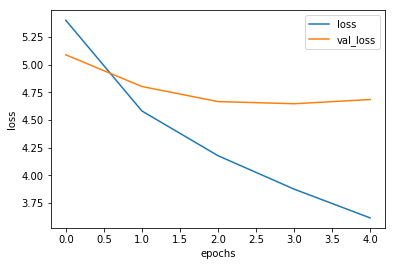

In [25]:
#Plotting the loss
for label in ["loss","val_loss"]:
    plt.plot(hist.history[label],label=label)
plt.legend()
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

Prediction

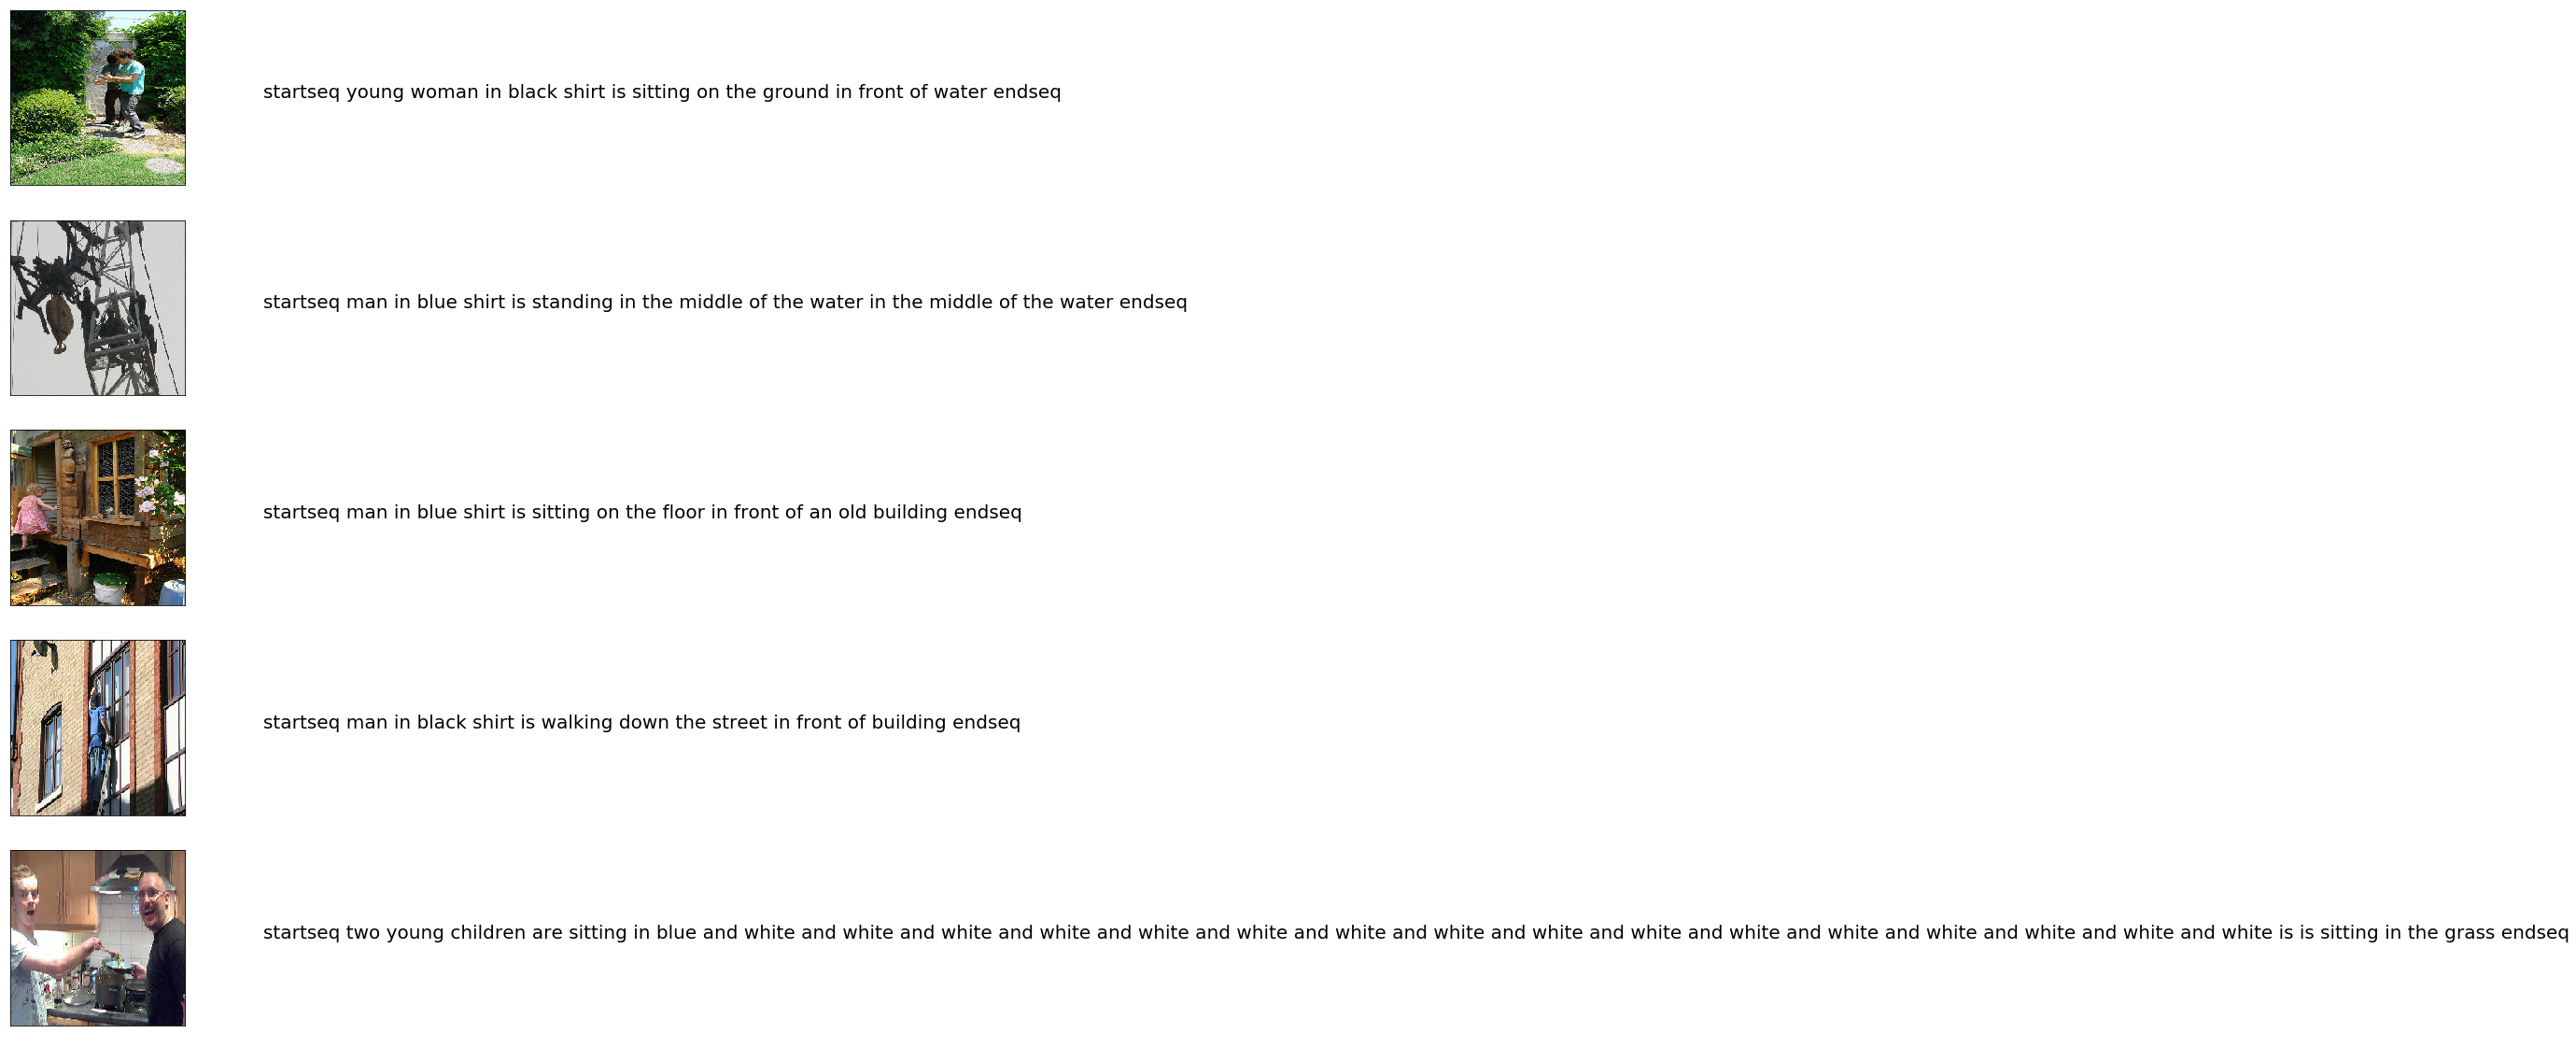

In [34]:
#Generating the caption
index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])
def predict_caption(image):
    '''
    image.shape = (1,4462)
    '''

    in_text = 'startseq'
    # iterate over the whole length of the sequence
    for iword in range(maxlen):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence],maxlen)
        # predict next word
        yhat = model.predict([image,sequence],verbose=0)
        yhat = np.argmax(yhat)
        newword = index_word[yhat]
        if newword is None:
            break
        in_text += " " + newword
        if newword == "endseq":
            break
    return(in_text)



npic = 5
npix = 224
target_size = (npix,npix,3)

count = 1
fig = plt.figure(figsize=(10,20))
for jpgfnm, image_feature in zip(fnm_test[:npic],di_test[:npic]):
    ## images 
    filename = data_image + '/' + jpgfnm
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.text(0,0.5,caption,fontsize=20)
    count += 1

plt.show()

Bleu score

In [28]:
#calculating blue score.
from nltk.translate.bleu_score import sentence_bleu

index_word = dict([(index,word) for word, index in tokenizer.word_index.items()])


nkeep = 5
pred_good, pred_bad, bleus = [], [], [] 
count = 0 
for jpgfnm, image_feature, tokenized_text in zip(fnm_test,di_test,dt_test):
    count += 1
    if count % 200 == 0:
        print("  {:4.2f}% is done..".format(100*count/float(len(fnm_test))))
    
    caption_true = [ index_word[i] for i in tokenized_text ]     
    caption_true = caption_true[1:-1] ## remove startseq, and endseq
    ## captions
    caption = predict_caption(image_feature.reshape(1,len(image_feature)))
    caption = caption.split()
    caption = caption[1:-1]## remove startseqg, and endseq
    
    bleu = sentence_bleu([caption_true],caption)
    bleus.append(bleu)
    if bleu > 0.4 and len(pred_good) < nkeep:
        pred_good.append((bleu,jpgfnm,caption_true,caption))
    elif bleu < 0.3 and len(pred_bad) < nkeep:
        pred_bad.append((bleu,jpgfnm,caption_true,caption))

C:\Users\DELL\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\DELL\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
C:\Users\DELL\Anaconda3\lib\site-packages\nltk\translate\bleu_score.py:503: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.

  2.10% is done..
  4.20% is done..
  6.29% is done..
  8.39% is done..
  10.49% is done..
  12.59% is done..
  14.68% is done..
  16.78% is done..
  18.88% is done..
  20.98% is done..
  23.08% is done..
  25.17% is done..
  27.27% is done..
  29.37% is done..
  31.47% is done..
  33.56% is done..
  35.66% is done..
  37.76% is done..
  39.86% is done..
  41.96% is done..
  44.05% is done..
  46.15% is done..
  48.25% is done..
  50.35% is done..
  52.44% is done..
  54.54% is done..
  56.64% is done..
  58.74% is done..
  60.83% is done..
  62.93% is done..
  65.03% is done..
  67.13% is done..
  69.23% is done..
  71.32% is done..
  73.42% is done..
  75.52% is done..
  77.62% is done..
  79.71% is done..
  81.81% is done..
  83.91% is done..
  86.01% is done..
  88.11% is done..
  90.20% is done..
  92.30% is done..
  94.40% is done..
  96.50% is done..
  98.59% is done..


In [30]:
print("Mean BLEU {:4.3f}".format(np.mean(bleus)))

Mean BLEU 0.004


Output:

Bad Caption


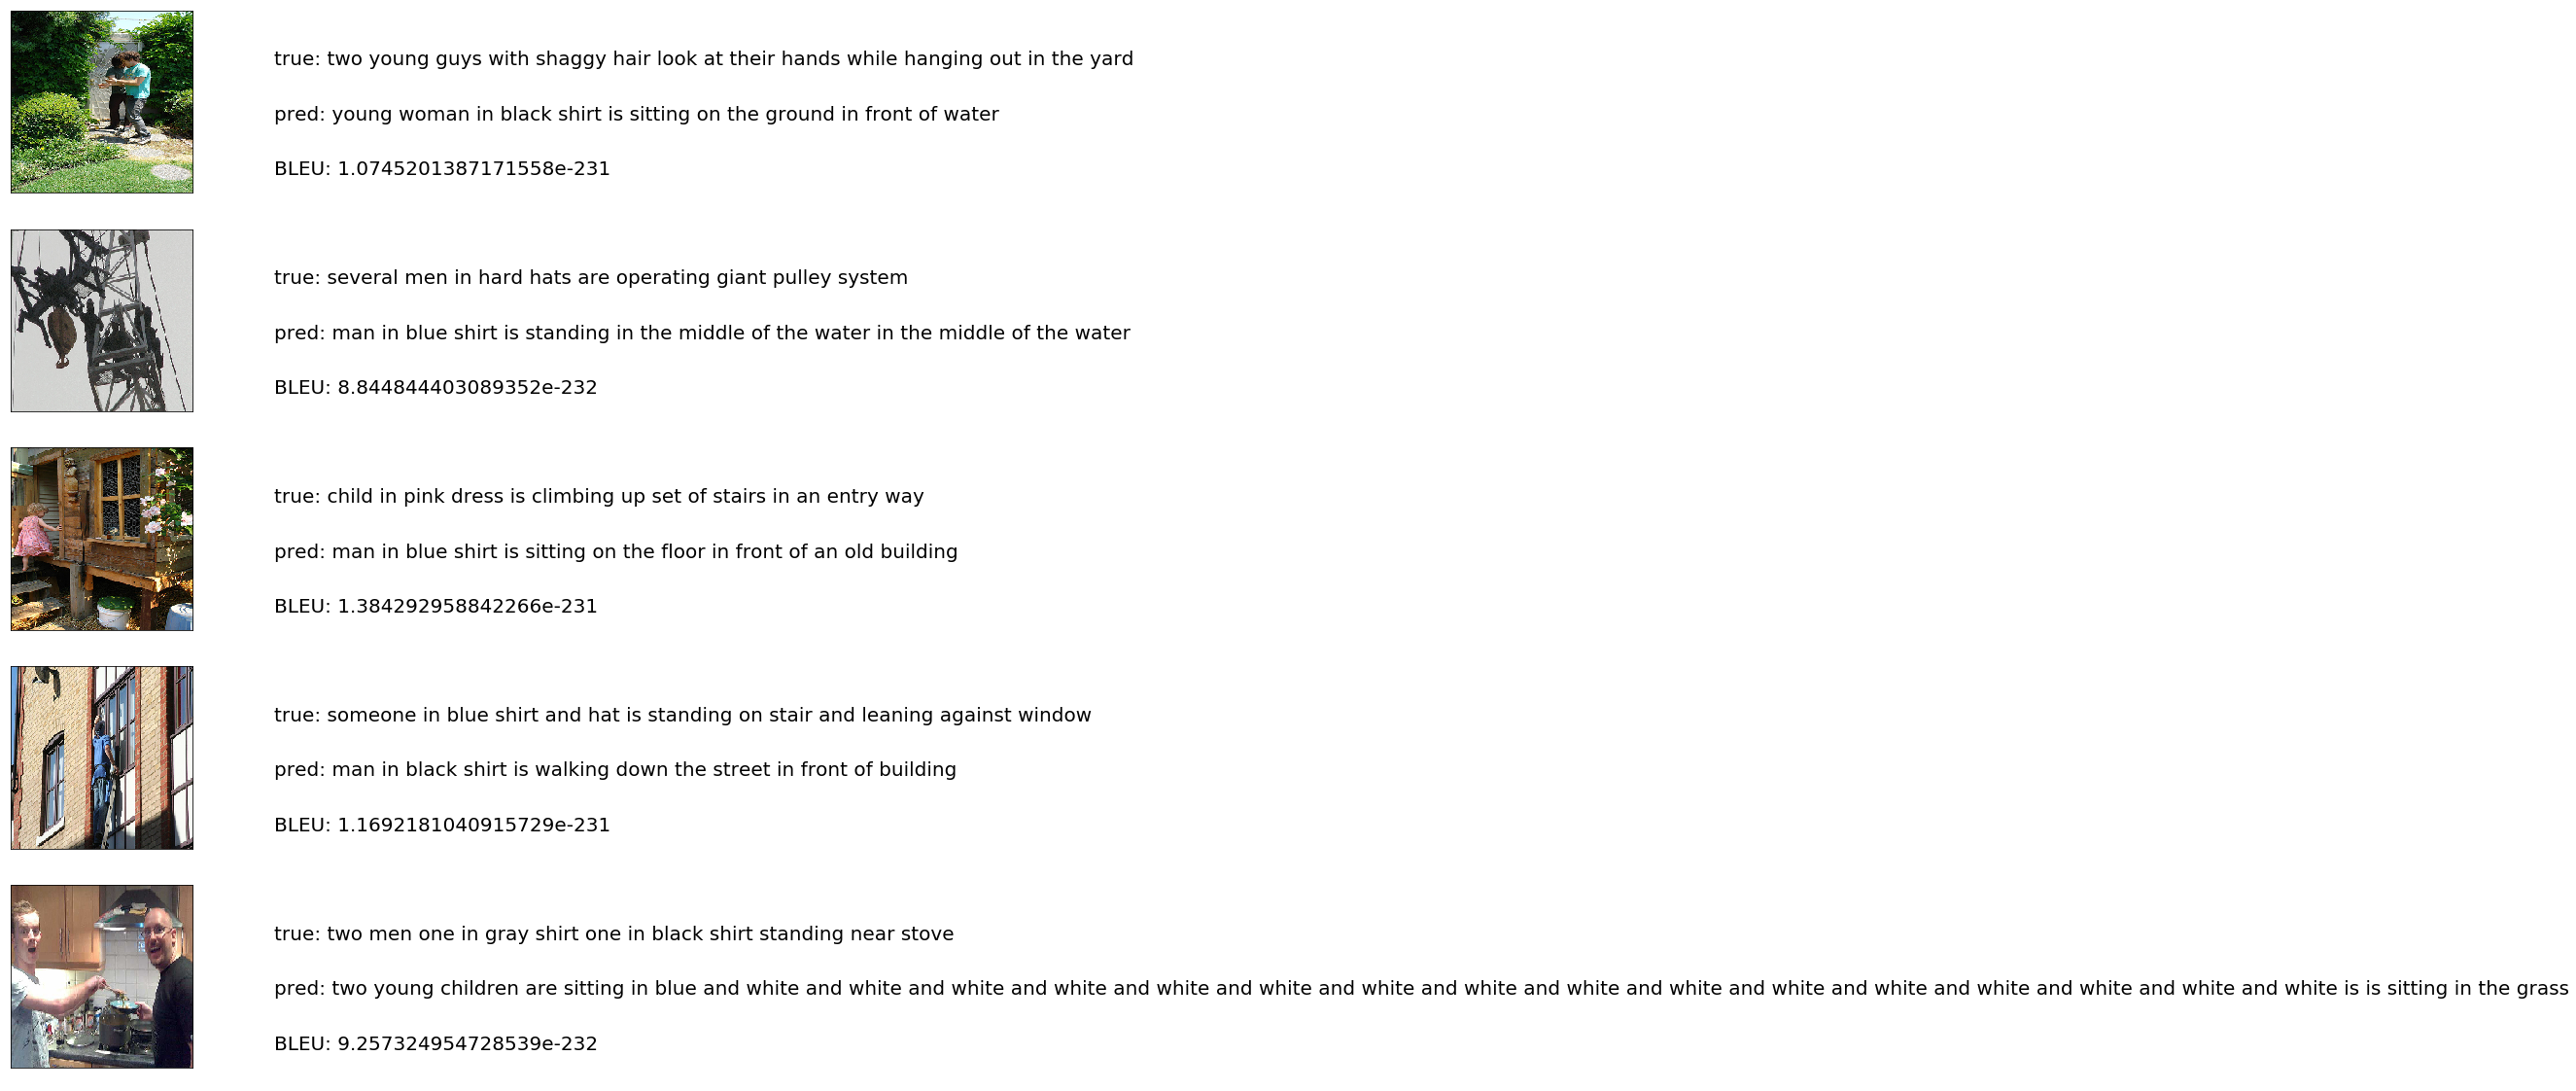

Good Caption


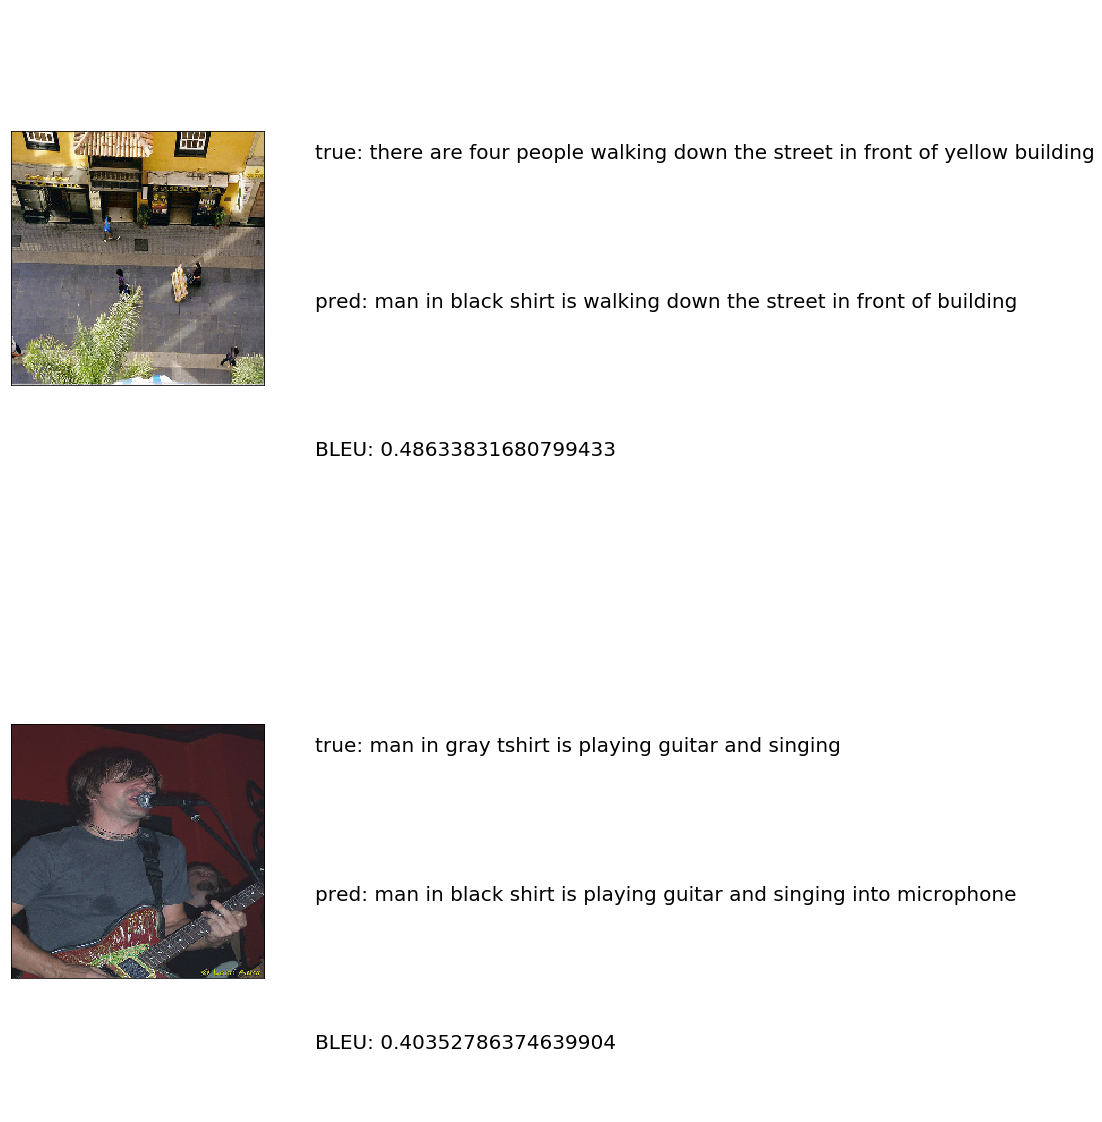

In [31]:
def plot_images(pred_bad):
    def create_str(caption_true):
        strue = ""
        for s in caption_true:
            strue += " " + s
        return(strue)
    npix = 224
    target_size = (npix,npix,3)    
    count = 1
    fig = plt.figure(figsize=(10,20))
    npic = len(pred_bad)
    for pb in pred_bad:
        bleu,jpgfnm,caption_true,caption = pb
        ## images 
        filename = data_image + '/' + jpgfnm
        image_load = load_img(filename, target_size=target_size)
        ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
        ax.imshow(image_load)
        count += 1

        caption_true = create_str(caption_true)
        caption = create_str(caption)
        
        ax = fig.add_subplot(npic,2,count)
        plt.axis('off')
        ax.plot()
        ax.set_xlim(0,1)
        ax.set_ylim(0,1)
        ax.text(0,0.7,"true:" + caption_true,fontsize=20)
        ax.text(0,0.4,"pred:" + caption,fontsize=20)
        ax.text(0,0.1,"BLEU: {}".format(bleu),fontsize=20)
        count += 1
    plt.show()

print("Bad Caption")
plot_images(pred_bad)
print("Good Caption")
plot_images(pred_good)
 